In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
!pip install --upgrade --no-cache-dir gdown
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

In [ ]:
!gdown 1w4cKxu1cI36_FGQHGyRFeOjDICSIamR_
!gdown 1IpUZzaXwj5E0apUZuz97T_wLQNOU8IVD
!gdown 1XbQVl-rCnsOYmMhcu7xVRoNrKrKtROaH
!gdown 1SSlcRlQ85h0uqdVnLpzynyZ8NXZVU5Dp

Downloading...
From (original): https://drive.google.com/uc?id=1w4cKxu1cI36_FGQHGyRFeOjDICSIamR_
From (redirected): https://drive.google.com/uc?id=1w4cKxu1cI36_FGQHGyRFeOjDICSIamR_&confirm=t&uuid=8d297800-b334-4ac1-9ab9-d6664b607073
To: /content/train_data_kc.zip
100% 50.8M/50.8M [00:01<00:00, 46.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IpUZzaXwj5E0apUZuz97T_wLQNOU8IVD
To: /content/test_data_kc.zip
100% 17.9M/17.9M [00:00<00:00, 177MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1XbQVl-rCnsOYmMhcu7xVRoNrKrKtROaH
From (redirected): https://drive.google.com/uc?id=1XbQVl-rCnsOYmMhcu7xVRoNrKrKtROaH&confirm=t&uuid=a6cee17c-ec10-4b3f-ae60-383c1d69e1d1
To: /content/train_data_two_class.zip
100% 36.2M/36.2M [00:00<00:00, 37.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SSlcRlQ85h0uqdVnLpzynyZ8NXZVU5Dp
To: /content/test_data_two_class.zip
100% 12.0M/12.0M [00:00<00:00, 30.4MB/s]


In [ ]:
import os
import zipfile
with zipfile.ZipFile("train_data_kc.zip", "r") as zip_ref:
  print("Unzipping file...")
  zip_ref.extractall("train_data_kc")

Unzipping file...


In [ ]:
with zipfile.ZipFile("train_data_two_class.zip", "r") as zip_ref:
  print("Unzipping file...")
  zip_ref.extractall("train_data_two_class")

Unzipping file...


In [ ]:
with zipfile.ZipFile("test_data_kc.zip", "r") as zip_ref:
  print("Unzipping file...")
  zip_ref.extractall("test_data_kc")

Unzipping file...


In [ ]:
with zipfile.ZipFile("test_data_two_class.zip", "r") as zip_ref:
  print("Unzipping file...")
  zip_ref.extractall("test_data_two_class")

Unzipping file...


In [ ]:
os.makedirs("module_funcs")

FileExistsError: [Errno 17] File exists: 'module_funcs'

In [ ]:
%%writefile module_funcs/data_setup.py
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  class_names = train_data.classes
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Overwriting module_funcs/data_setup.py


In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset
])

In [ ]:
from module_funcs import data_setup
train_dataloader , test_dataloader , class_names  = data_setup.create_dataloaders(train_dir = "/content/train_data_kc/train_data_kc" ,
                                                                                  test_dir = "/content/test_data_kc/test_data_kc" ,
                                                                                  transform = simple_transform ,
                                                                                  batch_size = 25)


In [ ]:
from module_funcs import data_setup
train_dataloader_two_class , test_dataloader_two_class , class_names_two_class  = data_setup.create_dataloaders(train_dir = "/content/train_data_two_class/train_data_two_class" ,
                                                                                  test_dir = "/content/test_data_two_class/test_data_two_class" ,
                                                                                  transform = simple_transform ,
                                                                                  batch_size = 25)


In [ ]:
%%writefile module_funcs/engine.py
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:



  model.eval()


  test_loss, test_acc = 0, 0

  with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)

          test_pred_logits = model(X)

          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:



  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  return results

Overwriting module_funcs/engine.py


In [ ]:
import torchvision
weights1 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
weights2 = torchvision.models.ResNet18_Weights.DEFAULT
weights3 = torchvision.models.VGG16_Weights.DEFAULT
weights4 = torchvision.models.Inception_V3_Weights.DEFAULT

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
auto_transforms = weights1.transforms()
model1 = torchvision.models.efficientnet_b2(weights=weights1).to(device)
model2 = torchvision.models.resnet18(weights=weights2).to(device)
model3 = torchvision.models.vgg16(weights = weights3).to(device)
model4 = torchvision.models.inception_v3(weights = weights4).to(device)
total_layers_model1 = sum(1 for _ in model1.parameters())
total_layers_model2 = sum(1 for _ in model2.parameters())
total_layers_model3 = sum(1 for _ in model3.parameters())
percent_freeze_model1 = 0.7
percent_freeze_model2 = 0.7
percent_freeze_model3 = 0.7
num_layers_freeze_model1 = int(percent_freeze_model1*total_layers_model1)
num_layers_freeze_model2 = int(percent_freeze_model2*total_layers_model2)
num_layers_freeze_model3 = int(percent_freeze_model3*total_layers_model3)
frozen_layers_model1 = 0
frozen_layers_model2 = 0
frozen_layers_model3 = 0
# for name , param in model1.named_parameters():
#   if "classifier" not in name:
#     if frozen_layers_model1 < num_layers_freeze_model1:
#       param.requires_grad = False
#       frozen_layers_model1 += 1
#     else:
#       break
# for name , param in model2.named_parameters():
#   if "classifier" not in name:
#     if frozen_layers_model2 < num_layers_freeze_model2:
#       param.requires_grad = False
#       frozen_layers_model2 += 1
#     else:
#       break
# for name , param in model3.named_parameters():
#   if "classifier" not in name:
#     if frozen_layers_model3 < num_layers_freeze_model3:
#       param.requires_grad = False
#       frozen_layers_model3 += 1
#     else:
#       break
for param in model1.parameters():
    param.requires_grad = True
for param in model2.parameters():
    param.requires_grad = True
for param in model3.parameters():
    param.requires_grad = True


In [ ]:
!pip install mahotas
import mahotas as mh
def compute_zernike_moment(image , radius , degree):
  if len(image.shape) > 2:
    image = mh.colors.rgb2grey(image)
  moments = mh.features.zernike_moments(image, radius, degree)
  return moments


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 24.5 MB/s eta 0:00:00


In [ ]:
class CNN_Model(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*64*64,
                      out_features=output_shape)
        )

  def forward(self, x: torch.Tensor):
      x = self.block_1(x)
      x = self.block_2(x)
      x = self.classifier(x)
      return x
torch.manual_seed(42)
model4 = CNN_Model(input_shape=3,
    hidden_units=40,
    output_shape=3).to(device)

In [ ]:
# %%writefile module_funcs/modeltest.py
# from module_funcs import engine
# import torch
# def model_tester(models:list ,
#                  train_dataloader: torch.utils.data.DataLoader,
#                  test_dataloader: torch.utils.data.DataLoader,
#                  optimizer: torch.optim.Optimizer,
#                  loss_fn: torch.nn.Module,
#                  epochs: int,
#                  device):
#   for i in range(len(models)):
#     print(f"model{i} result is:\n")
#     engine.train(model = models[i],
#                  train_dataloader=train_dataloader,
#                  test_dataloader=test_dataloader,
#                  optimizer=optimizer,
#                  loss_fn=loss_fn,
#                  epochs=epochs,
#                  device=device
#     )






In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


output_shape = len(class_names)
output_shape_2 = len(class_names_two_class)


# model1.classifier = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.2, inplace=True),
#     torch.nn.Linear(in_features=1408,
#                     out_features=output_shape,
#                     bias=True)).to(device)
model2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape,
                    bias=True)).to(device)
model3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape,
                    bias=True)).to(device)
model1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape_2,
                    bias=True)).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer_model1 = torch.optim.Adam(model1.parameters(), lr=0.01)
optimizer_model2 = torch.optim.Adam(model2.parameters(), lr=0.01)
optimizer_model3 = torch.optim.Adam(model3.parameters(), lr=0.01)
optimizer_model4 = torch.optim.Adam(model4.parameters(), lr=0.01)

In [ ]:
test_data = datasets.ImageFolder("/content/test_data_kc/test_data_kc", transform=data_transform)
test_data.targets = torch.Tensor(test_data.targets)
test_data_2 = datasets.ImageFolder("/content/test_data_two_class/test_data_two_class", transform=data_transform)
test_data_2.targets = torch.Tensor(test_data_2.targets)


In [ ]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results2 = engine.train(model=model1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer_model1,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5176 | train_acc: 0.7731 | test_loss: 1.4243 | test_acc: 0.3867
Epoch: 2 | train_loss: 0.5245 | train_acc: 0.7331 | test_loss: 0.9047 | test_acc: 0.5133
Epoch: 3 | train_loss: 0.4991 | train_acc: 0.7733 | test_loss: 0.8020 | test_acc: 0.6733
Epoch: 4 | train_loss: 0.4979 | train_acc: 0.7532 | test_loss: 0.7799 | test_acc: 0.6267
Epoch: 5 | train_loss: 0.5466 | train_acc: 0.7584 | test_loss: 1.4405 | test_acc: 0.5133
Epoch: 6 | train_loss: 0.4886 | train_acc: 0.7709 | test_loss: 1.1171 | test_acc: 0.5600
Epoch: 7 | train_loss: 0.4081 | train_acc: 0.8245 | test_loss: 1.3825 | test_acc: 0.6000
Epoch: 8 | train_loss: 0.3132 | train_acc: 0.8649 | test_loss: 0.8542 | test_acc: 0.6467
Epoch: 9 | train_loss: 0.4017 | train_acc: 0.8157 | test_loss: 1.5632 | test_acc: 0.5267
Epoch: 10 | train_loss: 0.2991 | train_acc: 0.8886 | test_loss: 1.0253 | test_acc: 0.6867
Total training time: 72.472 seconds


Making predictions:   0%|          | 0/6 [00:00<?, ?it/s]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.7 MB/s eta 0:00:00


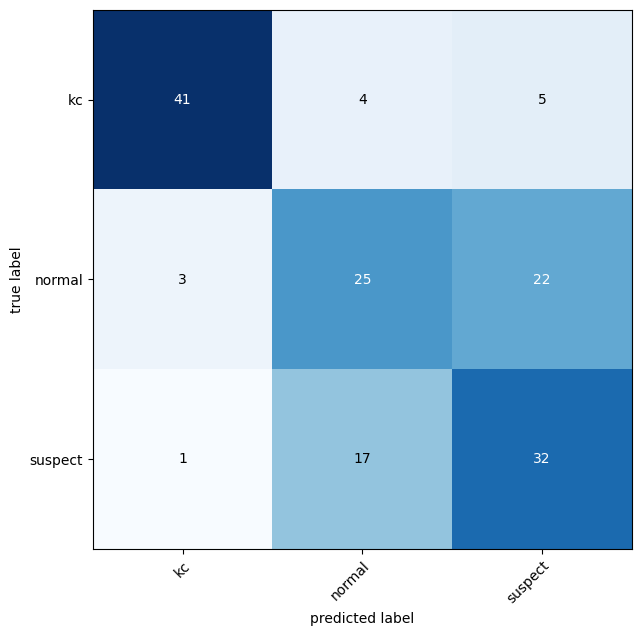

In [ ]:
from tqdm.auto import tqdm
y_preds = []
model1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model1(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model1 = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model1,
                         target=test_data.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

In [ ]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results2 = engine.train(model=model1,
                       train_dataloader=train_dataloader_two_class,
                       test_dataloader=test_dataloader_two_class,
                       optimizer=optimizer_model1,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.4960 | train_acc: 0.8033 | test_loss: 15880.6392 | test_acc: 0.5000
Epoch: 2 | train_loss: 0.2783 | train_acc: 0.9200 | test_loss: 4405.8959 | test_acc: 0.4900
Epoch: 3 | train_loss: 0.2843 | train_acc: 0.9167 | test_loss: 70.9551 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.2535 | train_acc: 0.9267 | test_loss: 1.4179 | test_acc: 0.8500
Epoch: 5 | train_loss: 0.2108 | train_acc: 0.9267 | test_loss: 1.8811 | test_acc: 0.6600
Epoch: 6 | train_loss: 0.1512 | train_acc: 0.9433 | test_loss: 0.6057 | test_acc: 0.6600
Epoch: 7 | train_loss: 0.1388 | train_acc: 0.9733 | test_loss: 0.6903 | test_acc: 0.6800
Epoch: 8 | train_loss: 0.0652 | train_acc: 0.9800 | test_loss: 0.1969 | test_acc: 0.8800
Epoch: 9 | train_loss: 0.0337 | train_acc: 0.9867 | test_loss: 1.7162 | test_acc: 0.7000
Epoch: 10 | train_loss: 0.0386 | train_acc: 0.9900 | test_loss: 0.3636 | test_acc: 0.9000
Total training time: 1291.264 seconds


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Making predictions:   0%|          | 0/4 [00:00<?, ?it/s]

mlxtend version: 0.23.1


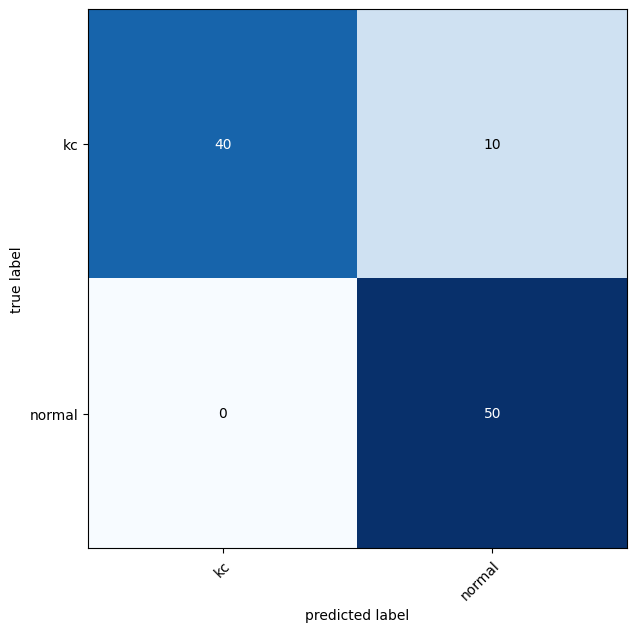

In [ ]:
from tqdm.auto import tqdm
y_preds = []
model1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_two_class, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model1(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model1 = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names_two_class), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model1,
                         target=test_data_2.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names_two_class,
    figsize=(10, 7)
);

In [ ]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results2 = engine.train(model=model4,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer_model4,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0994 | train_acc: 0.2913 | test_loss: 1.0982 | test_acc: 0.3400
Epoch: 2 | train_loss: 1.0995 | train_acc: 0.2913 | test_loss: 1.0982 | test_acc: 0.3400
Epoch: 3 | train_loss: 1.0995 | train_acc: 0.2904 | test_loss: 1.0983 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0995 | train_acc: 0.2910 | test_loss: 1.0983 | test_acc: 0.3400
Epoch: 5 | train_loss: 1.0994 | train_acc: 0.2908 | test_loss: 1.0985 | test_acc: 0.3333
Total training time: 908.855 seconds


Making predictions:   0%|          | 0/6 [00:00<?, ?it/s]

mlxtend version: 0.23.1


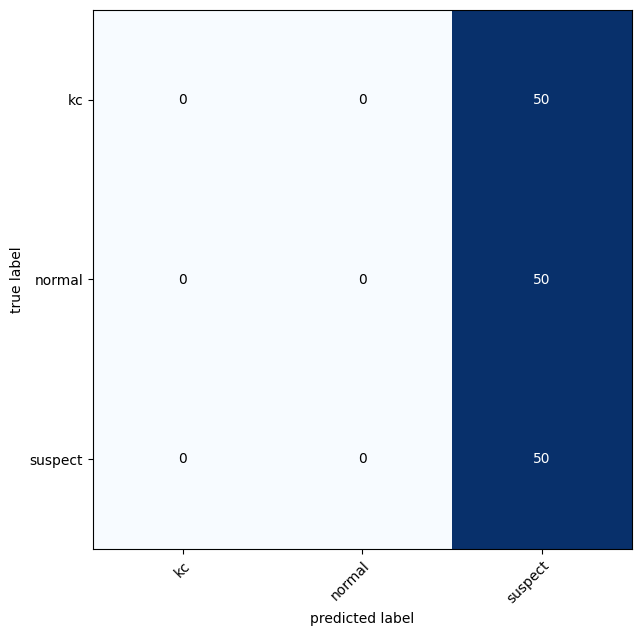

In [ ]:
from tqdm.auto import tqdm
y_preds = []
model1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model4(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model4 = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model4,
                         target=test_data.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

In [ ]:
%%writefile module_funcs/model_save.py
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)






Writing module_funcs/model_save.py


In [ ]:
from module_funcs.model_save import save_model
save_filepath = "model_efficientB0.pth"
save_model(model=model1,
           target_dir="models",
           model_name=save_filepath)



[INFO] Saving model to: models/model_efficientB0.pth


In [ ]:
def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    torch.cuda.manual_seed(42)
    torch.manual_seed(42)
    output_shape = len(class_names)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=output_shape)
    ).to(device)

    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model
def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    torch.cuda.manual_seed(42)
    torch.manual_seed(42)
    output_shape = len(class_names)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=output_shape)
    ).to(device)

    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [ ]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():

    from datetime import datetime
    import os

    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [ ]:
%%writefile module_funcs/train_write.py
from typing import Dict, List , Tuple
from tqdm.auto import tqdm
import torch
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:



  model.eval()


  test_loss, test_acc = 0, 0

  with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)

          test_pred_logits = model(X)

          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc
def train_writer(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            writer.close()
        else:
            pass
    return results

Writing module_funcs/train_write.py


In [ ]:
%%time
from module_funcs.model_save import save_model
from module_funcs import train_write

# 1. Set the random seeds
torch.cuda.manual_seed(42)
torch.manual_seed(42)
train_dataloaders = train_dataloader
num_epochs = [5 , 10]
models = ["effnetb0", "effnetb2"]
experiment_number = 0
dataloader_name = 'org_dataloader'

for epochs in num_epochs:

    for model_name in models:

        experiment_number += 1
        print(f"[INFO] Experiment number: {experiment_number}")
        print(f"[INFO] Model: {model_name}")
        print(f"[INFO] DataLoader: {dataloader_name}")
        print(f"[INFO] Number of epochs: {epochs}")

        if model_name == "effnetb0":
            model = create_effnetb0()
        else:
            model = create_effnetb2()

        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

        train_write.train_writer(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=epochs,
              device=device,
              writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))

        save_filepath = f"model_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
        save_model(model=model,
                    target_dir="models",
                    model_name=save_filepath)
        print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: org_dataloader
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-05-03/org_dataloader/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9373 | train_acc: 0.5842 | test_loss: 0.8592 | test_acc: 0.6000
Epoch: 2 | train_loss: 0.7083 | train_acc: 0.6925 | test_loss: 0.7752 | test_acc: 0.6067
Epoch: 3 | train_loss: 0.6088 | train_acc: 0.7543 | test_loss: 0.7910 | test_acc: 0.6200
Epoch: 4 | train_loss: 0.5352 | train_acc: 0.7949 | test_loss: 0.7684 | test_acc: 0.6467
Epoch: 5 | train_loss: 0.5372 | train_acc: 0.7757 | test_loss: 0.7605 | test_acc: 0.6467
[INFO] Saving model to: models/model_effnetb0_org_dataloader_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: org_dataloader
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-05-03/org_dataloader/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9306 | train_acc: 0.5772 | test_loss: 0.8966 | test_acc: 0.5667
Epoch: 2 | train_loss: 0.7172 | train_acc: 0.7111 | test_loss: 0.7907 | test_acc: 0.5867
Epoch: 3 | train_loss: 0.6324 | train_acc: 0.7476 | test_loss: 0.7634 | test_acc: 0.5933
Epoch: 4 | train_loss: 0.5968 | train_acc: 0.7535 | test_loss: 0.7361 | test_acc: 0.6000
Epoch: 5 | train_loss: 0.5748 | train_acc: 0.7709 | test_loss: 0.7509 | test_acc: 0.5800
[INFO] Saving model to: models/model_effnetb2_org_dataloader_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: org_dataloader
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-05-03/org_dataloader/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9373 | train_acc: 0.5842 | test_loss: 0.8592 | test_acc: 0.6000
Epoch: 2 | train_loss: 0.7083 | train_acc: 0.6925 | test_loss: 0.7752 | test_acc: 0.6067
Epoch: 3 | train_loss: 0.6088 | train_acc: 0.7543 | test_loss: 0.7910 | test_acc: 0.6200
Epoch: 4 | train_loss: 0.5352 | train_acc: 0.7949 | test_loss: 0.7684 | test_acc: 0.6467
Epoch: 5 | train_loss: 0.5372 | train_acc: 0.7757 | test_loss: 0.7605 | test_acc: 0.6467
Epoch: 6 | train_loss: 0.5036 | train_acc: 0.8039 | test_loss: 0.7773 | test_acc: 0.6600
Epoch: 7 | train_loss: 0.5160 | train_acc: 0.7919 | test_loss: 0.7661 | test_acc: 0.6667
Epoch: 8 | train_loss: 0.4656 | train_acc: 0.8041 | test_loss: 0.8018 | test_acc: 0.6267
Epoch: 9 | train_loss: 0.4821 | train_acc: 0.7968 | test_loss: 0.7572 | test_acc: 0.6867
Epoch: 10 | train_loss: 0.4556 | train_acc: 0.8129 | test_loss: 0.7901 | test_acc: 0.6267
[INFO] Saving model to: models/model_effnetb0_org_dataloader_10_epochs.pth
----------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9306 | train_acc: 0.5772 | test_loss: 0.8966 | test_acc: 0.5667
Epoch: 2 | train_loss: 0.7172 | train_acc: 0.7111 | test_loss: 0.7907 | test_acc: 0.5867
Epoch: 3 | train_loss: 0.6324 | train_acc: 0.7476 | test_loss: 0.7634 | test_acc: 0.5933
Epoch: 4 | train_loss: 0.5968 | train_acc: 0.7535 | test_loss: 0.7361 | test_acc: 0.6000
Epoch: 5 | train_loss: 0.5748 | train_acc: 0.7709 | test_loss: 0.7509 | test_acc: 0.5800
Epoch: 6 | train_loss: 0.5165 | train_acc: 0.8105 | test_loss: 0.7481 | test_acc: 0.5933
Epoch: 7 | train_loss: 0.4986 | train_acc: 0.7784 | test_loss: 0.7354 | test_acc: 0.6067
Epoch: 8 | train_loss: 0.5097 | train_acc: 0.8180 | test_loss: 0.7474 | test_acc: 0.5867
Epoch: 9 | train_loss: 0.4574 | train_acc: 0.8370 | test_loss: 0.7508 | test_acc: 0.6067
Epoch: 10 | train_loss: 0.4806 | train_acc: 0.7943 | test_loss: 0.7525 | test_acc: 0.6200
[INFO] Saving model to: models/model_effnetb2_org_dataloader_10_epochs.pth
----------------------------------

In [ ]:
best_model_path = "/content/models/model_effnetb0_org_dataloader_10_epochs.pth"
best_model = create_effnetb0()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb0 model.


<All keys matched successfully>

In [ ]:
from typing import List, Tuple
from PIL import Image
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

    img = Image.open(image_path)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    model.to(device)
    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)

      target_image_pred = model(transformed_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

In [ ]:
os.makedirs("test_images")

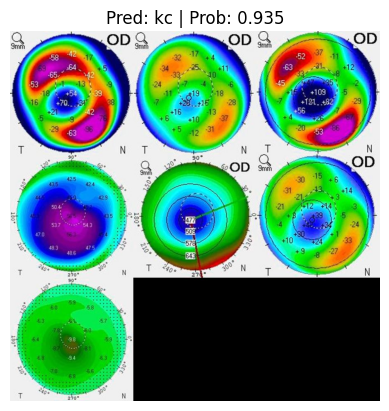

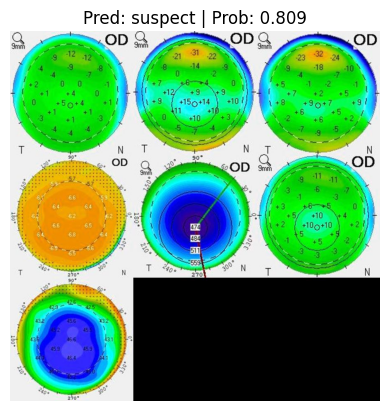

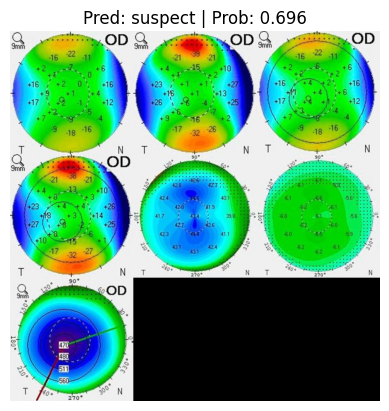

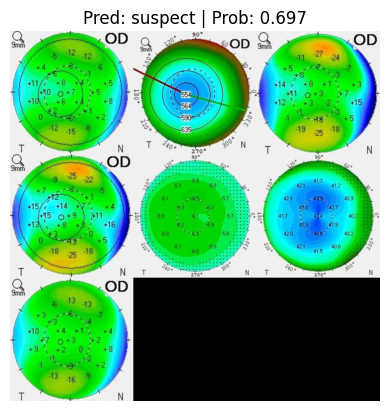

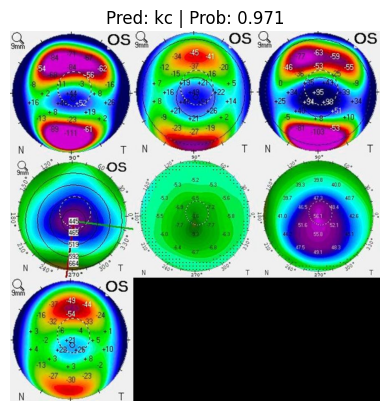

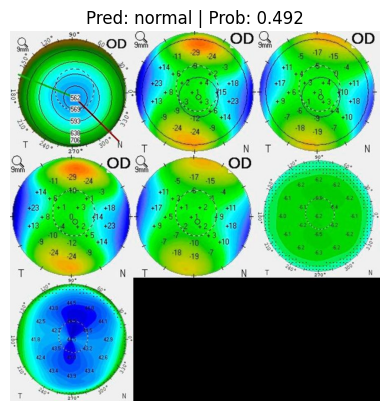

In [ ]:
from pathlib import Path
# list(Path(test_images).glob("*/*.jpg"))
test_image_path_sample = ['/content/test_images/case1.jpg' , '/content/test_images/case19.jpg' , '/content/test_images/case24.jpg' , '/content/test_images/case3.jpg' , '/content/test_images/case6.jpg' , '/content/test_images/case8.jpg']
for image_path in test_image_path_sample:
  pred_and_plot_image(model=best_model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

In [ ]:
from tqdm.auto import tqdm
y_preds = []
model1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model5(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model5 = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model5,
                         target=test_data.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models


model11 = models.resnet18(pretrained=True)
model22 = models.vgg16(pretrained=True)
model33 = models.efficientnet_b0(pretrained=True)
for param in model11.parameters():
    param.requires_grad = False
for param in model33.parameters():
    param.requires_grad = False

num_classes=len(class_names)

class FusionModel(nn.Module):
    def __init__(self, model1, model2, model3):
        super(FusionModel, self).__init__()

        self.fc1 = nn.Linear(3 * 1000, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.model1 = model11
        self.model2 = model22
        self.model3 = model33

    def forward(self, x):

        out1 = self.model1(x)
        out2 = self.model2(x)
        out3 = self.model3(x)

        out = torch.cat((out1, out2, out3), dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


device = "cuda" if torch.cuda.is_available() else "cpu"
fusion_model = FusionModel(model11 , model22 , model33).to(device)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
 

Making predictions:   0%|          | 0/6 [00:00<?, ?it/s]

mlxtend version: 0.23.1


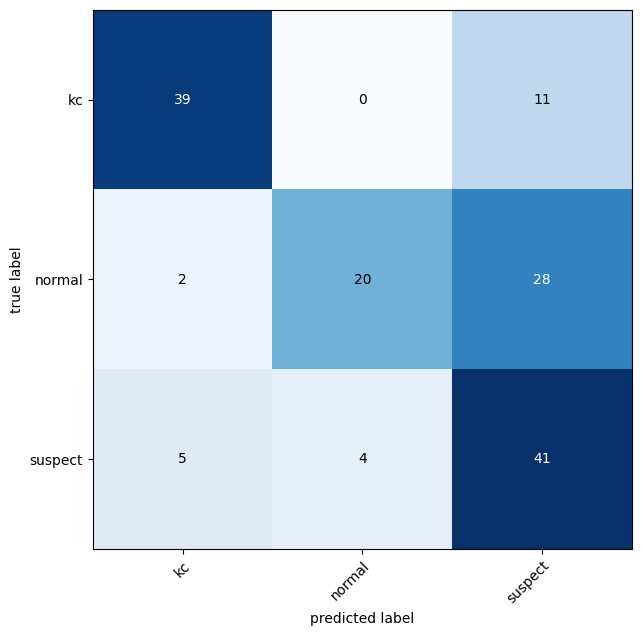

In [ ]:
from tqdm.auto import tqdm
y_preds = []
fusion_model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = fusion_model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_fusion = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_fusion,
                         target=test_data.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

In [ ]:
fusion_model

FusionModel(
  (fc1): Linear(in_features=3000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

In [ ]:
!pip install timm

In [ ]:

import timm
device = "cuda" if torch.cuda.is_available() else "cpu"


# Load a pretrained ViT model
model_ptch = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=output_shape)  # Adjust `num_classes` as needed
 # Move model to GPU if available
model_ptch.to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
output_shape

3

In [ ]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=32,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.patch_size = patch_size
        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1)

In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [ ]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [ ]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=32, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
vit_manual_model = ViT(num_classes=len(class_names)).to(device)

In [ ]:
from module_funcs import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer_manual_vit = torch.optim.Adam(params=vit_manual_model.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model and save the training results to a dictionary
results = engine.train(model=vit_manual_model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer_manual_vit,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8933 | train_acc: 0.3618 | test_loss: 1.3469 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.1510 | train_acc: 0.3640 | test_loss: 1.1093 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0997 | train_acc: 0.3648 | test_loss: 1.1789 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.1313 | train_acc: 0.3446 | test_loss: 1.0993 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.1753 | train_acc: 0.2981 | test_loss: 1.1278 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.1854 | train_acc: 0.3589 | test_loss: 1.1071 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.1400 | train_acc: 0.3687 | test_loss: 1.1525 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.1127 | train_acc: 0.3351 | test_loss: 1.1189 | test_acc: 0.3333
Epoch: 9 | train_loss: 1.1192 | train_acc: 0.3238 | test_loss: 1.1142 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.1231 | train_acc: 0.3263 | test_loss: 1.1137 | test_acc: 0.3333


In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
optimizer_vit = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir="/content/train_data_kc/train_data_kc",
                                                                                                     test_dir="/content/test_data_kc/test_data_kc",
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [ ]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer_vit,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.4680 | train_acc: 0.8109 | test_loss: 1.0314 | test_acc: 0.5250
Epoch: 2 | train_loss: 0.4403 | train_acc: 0.8304 | test_loss: 1.0499 | test_acc: 0.5062
Epoch: 3 | train_loss: 0.4339 | train_acc: 0.8259 | test_loss: 1.0343 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.4426 | train_acc: 0.8326 | test_loss: 1.0142 | test_acc: 0.5125
Epoch: 5 | train_loss: 0.4362 | train_acc: 0.8326 | test_loss: 1.0346 | test_acc: 0.5125
Epoch: 6 | train_loss: 0.4375 | train_acc: 0.8246 | test_loss: 1.0279 | test_acc: 0.5125
Epoch: 7 | train_loss: 0.4445 | train_acc: 0.8189 | test_loss: 1.0457 | test_acc: 0.5125
Epoch: 8 | train_loss: 0.4264 | train_acc: 0.8326 | test_loss: 1.0521 | test_acc: 0.5125
Epoch: 9 | train_loss: 0.4315 | train_acc: 0.8268 | test_loss: 1.0271 | test_acc: 0.5125
Epoch: 10 | train_loss: 0.4432 | train_acc: 0.8202 | test_loss: 1.0451 | test_acc: 0.5125
Total training time: 99.118 seconds


In [ ]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)
optimizer_vit2 = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.001)
from timeit import default_timer as timer
start_time = timer()
pretrained_vit_results2 = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer_vit2,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8713 | train_acc: 0.6448 | test_loss: 0.9651 | test_acc: 0.4750
Epoch: 2 | train_loss: 0.6305 | train_acc: 0.7140 | test_loss: 0.9550 | test_acc: 0.4875
Epoch: 3 | train_loss: 0.5523 | train_acc: 0.7768 | test_loss: 0.9848 | test_acc: 0.4938
Epoch: 4 | train_loss: 0.5506 | train_acc: 0.7787 | test_loss: 1.1694 | test_acc: 0.4750
Epoch: 5 | train_loss: 0.5310 | train_acc: 0.7835 | test_loss: 1.0803 | test_acc: 0.4875
Epoch: 6 | train_loss: 0.5021 | train_acc: 0.8001 | test_loss: 1.0809 | test_acc: 0.4875
Epoch: 7 | train_loss: 0.5012 | train_acc: 0.8122 | test_loss: 1.0177 | test_acc: 0.4813
Epoch: 8 | train_loss: 0.4661 | train_acc: 0.8170 | test_loss: 0.9779 | test_acc: 0.5125
Epoch: 9 | train_loss: 0.4642 | train_acc: 0.8090 | test_loss: 1.0804 | test_acc: 0.4938
Epoch: 10 | train_loss: 0.4620 | train_acc: 0.8335 | test_loss: 0.9710 | test_acc: 0.5312
Total training time: 95.996 seconds


In [ ]:
pretrained_vit_2_weights = torchvision.models.ViT_B_32_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit_2 = torchvision.models.vit_b_32(weights=pretrained_vit_2_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit_2.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_2.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:02<00:00, 161MB/s]


In [ ]:
pretrained_vit_2_transforms = pretrained_vit_2_weights.transforms()
optimizer_vit_2 = torch.optim.Adam(params=pretrained_vit_2.parameters(),
                             lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
train_dataloader_pretrained_2, test_dataloader_pretrained_2, class_names = data_setup.create_dataloaders(train_dir="/content/train_data_kc/train_data_kc",
                                                                                                     test_dir="/content/test_data_kc/test_data_kc",
                                                                                                     transform=pretrained_vit_2_transforms,
                                                                                                     batch_size=32)

In [ ]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)
optimizer_vit_2 = torch.optim.Adam(params=pretrained_vit_2.parameters(),
                             lr=0.001)
from timeit import default_timer as timer
start_time = timer()
pretrained_vit_results_b_32 = engine.train(model=pretrained_vit_2,
                                      train_dataloader=train_dataloader_pretrained_2,
                                      test_dataloader=test_dataloader_pretrained_2,
                                      optimizer=optimizer_vit_2,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.8517 | train_acc: 0.6113 | test_loss: 0.8075 | test_acc: 0.6125
Epoch: 2 | train_loss: 0.6249 | train_acc: 0.7117 | test_loss: 0.7470 | test_acc: 0.6062
Epoch: 3 | train_loss: 0.5459 | train_acc: 0.7567 | test_loss: 0.8283 | test_acc: 0.6062
Epoch: 4 | train_loss: 0.5494 | train_acc: 0.7564 | test_loss: 0.8744 | test_acc: 0.6062
Epoch: 5 | train_loss: 0.5251 | train_acc: 0.7701 | test_loss: 0.8367 | test_acc: 0.6062
Epoch: 6 | train_loss: 0.4994 | train_acc: 0.7911 | test_loss: 0.8206 | test_acc: 0.6000
Epoch: 7 | train_loss: 0.4869 | train_acc: 0.7832 | test_loss: 0.8266 | test_acc: 0.6000
Epoch: 8 | train_loss: 0.4672 | train_acc: 0.8112 | test_loss: 0.7874 | test_acc: 0.6062
Epoch: 9 | train_loss: 0.4540 | train_acc: 0.8214 | test_loss: 0.8421 | test_acc: 0.6000
Epoch: 10 | train_loss: 0.4551 | train_acc: 0.8033 | test_loss: 0.8109 | test_acc: 0.6000
Total training time: 79.225 seconds


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Making predictions:   0%|          | 0/5 [00:00<?, ?it/s]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.9 MB/s eta 0:00:00


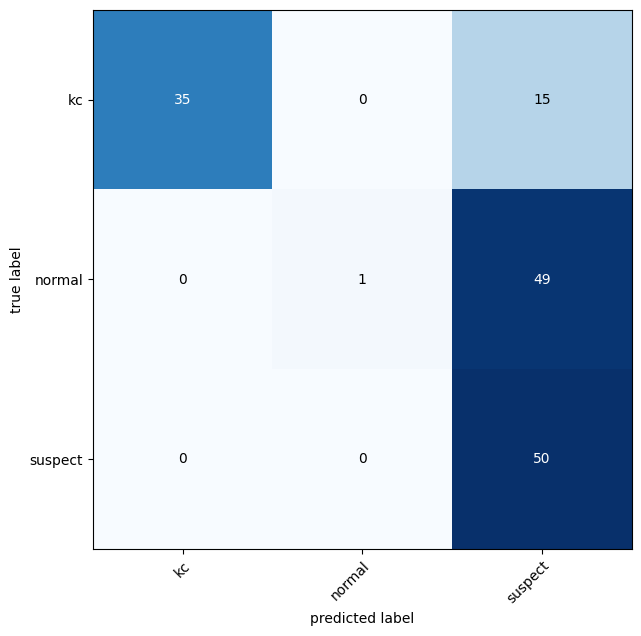

In [ ]:
from tqdm.auto import tqdm
y_preds = []
pretrained_vit_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_pretrained_2, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = pretrained_vit_2(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_ptch = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_ptch,
                         target=test_data.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

In [ ]:
pretrained_vit_3_weights = torchvision.models.ViT_H_14_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit_3 = torchvision.models.vit_h_14(weights=pretrained_vit_3_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit_3.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_3.heads = nn.Linear(in_features=1280, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [ ]:
pretrained_vit_3_transforms = pretrained_vit_3_weights.transforms()
optimizer_vit_3 = torch.optim.Adam(params=pretrained_vit_3.parameters(),
                             lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
train_dataloader_pretrained_3, test_dataloader_pretrained_3, class_names = data_setup.create_dataloaders(train_dir="/content/train_data_kc/train_data_kc",
                                                                                                     test_dir="/content/test_data_kc/test_data_kc",
                                                                                                     transform=pretrained_vit_3_transforms,
                                                                                                     batch_size=32)

In [ ]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)
optimizer_vit_3 = torch.optim.Adam(params=pretrained_vit_3.parameters(),
                             lr=0.001)
from timeit import default_timer as timer
start_time = timer()
pretrained_vit_results_h_14 = engine.train(model=pretrained_vit_3,
                                      train_dataloader=train_dataloader_pretrained_3,
                                      test_dataloader=test_dataloader_pretrained_3,
                                      optimizer=optimizer_vit_3,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8500 | train_acc: 0.5989 | test_loss: 0.9794 | test_acc: 0.5312
Epoch: 2 | train_loss: 0.6212 | train_acc: 0.6939 | test_loss: 0.9057 | test_acc: 0.5750
Epoch: 3 | train_loss: 0.5460 | train_acc: 0.7567 | test_loss: 0.7344 | test_acc: 0.6534
Epoch: 4 | train_loss: 0.5446 | train_acc: 0.7522 | test_loss: 0.9066 | test_acc: 0.5813
Epoch: 5 | train_loss: 0.4904 | train_acc: 0.7809 | test_loss: 1.0464 | test_acc: 0.5750
Epoch: 6 | train_loss: 0.5045 | train_acc: 0.7621 | test_loss: 0.9307 | test_acc: 0.6062
Epoch: 7 | train_loss: 0.4598 | train_acc: 0.8045 | test_loss: 1.0505 | test_acc: 0.5938
Epoch: 8 | train_loss: 0.4573 | train_acc: 0.8045 | test_loss: 0.8213 | test_acc: 0.6375
Epoch: 9 | train_loss: 0.4579 | train_acc: 0.7924 | test_loss: 1.1528 | test_acc: 0.5125
Epoch: 10 | train_loss: 0.4447 | train_acc: 0.8147 | test_loss: 0.8868 | test_acc: 0.6000
Total training time: 4561.303 seconds


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Making predictions:   0%|          | 0/5 [00:00<?, ?it/s]

mlxtend version: 0.23.1


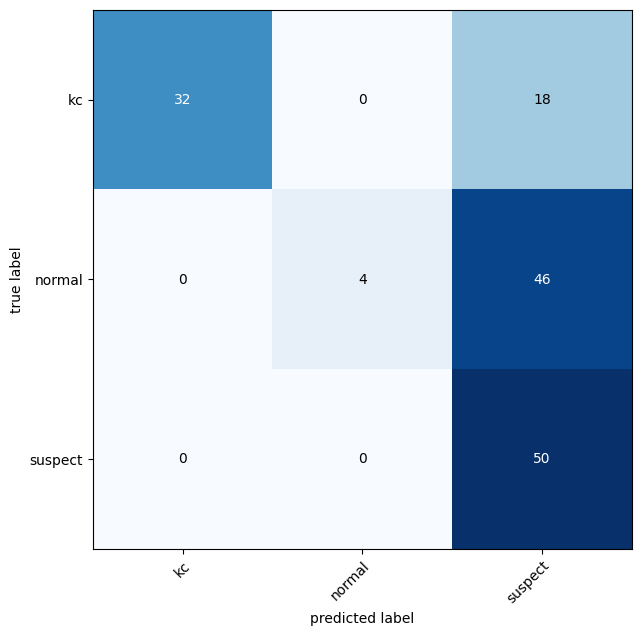

In [ ]:
from tqdm.auto import tqdm
y_preds = []
pretrained_vit_3.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_pretrained_3, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = pretrained_vit_3(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_ptch_2 = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_ptch_2,
                         target=test_data.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, vit_b_16

# Load pre-trained EfficientNet-B0
efficientnet = efficientnet_b0(pretrained=True)
efficientnet.classifier = nn.Identity()  # Remove the classification layer to get feature output

# Freeze EfficientNet-B0 parameters
for param in efficientnet.parameters():
    param.requires_grad = False

# Load pre-trained ViT-B/16
vit = vit_b_16(pretrained=True)
vit.heads = nn.Identity()  # Remove the classification head to get embeddings

# Freeze ViT-B/16 parameters
for param in vit.parameters():
    param.requires_grad = False


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 160MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights

Model with combining `vit` and `efficientb0`

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, efficientnet, vit, feature_dim, vit_dim, num_classes):
        super(CombinedModel, self).__init__()
        self.efficientnet = efficientnet
        self.vit = vit
        self.combined_dim = feature_dim + vit_dim
        self.classifier = nn.Linear(self.combined_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():  # Ensure EfficientNet-B0 features are not backpropagated
            efficientnet_features = self.efficientnet(x)

        with torch.no_grad():  # Ensure ViT features are not backpropagated
            vit_embeddings = self.vit(x)

        # Concatenate features and embeddings
        combined_features = torch.cat((efficientnet_features, vit_embeddings), dim=1)

        # Pass through the classifier
        output = self.classifier(combined_features)
        return output

# Assuming efficientnet feature dim is 1280 and ViT embedding dim is 768
combined_model_vit_eff = CombinedModel(efficientnet, vit, feature_dim=1280, vit_dim=768, num_classes=3).to(device)


In [ ]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)
optimizer_vit_eff = torch.optim.Adam(params=combined_model_vit_eff.parameters(),
                             lr=0.001)
from timeit import default_timer as timer
start_time = timer()
pretrained_vit_results_h_14 = engine.train(model=combined_model_vit_eff,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer_vit_eff,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.8009 | train_acc: 0.6805 | test_loss: 0.8853 | test_acc: 0.5250
Epoch: 2 | train_loss: 0.5473 | train_acc: 0.7742 | test_loss: 0.8699 | test_acc: 0.5813
Epoch: 3 | train_loss: 0.4709 | train_acc: 0.8291 | test_loss: 0.8416 | test_acc: 0.6125
Epoch: 4 | train_loss: 0.4721 | train_acc: 0.8099 | test_loss: 0.9804 | test_acc: 0.5750
Epoch: 5 | train_loss: 0.4233 | train_acc: 0.8214 | test_loss: 0.9961 | test_acc: 0.5938
Epoch: 6 | train_loss: 0.3937 | train_acc: 0.8594 | test_loss: 1.0081 | test_acc: 0.5813
Epoch: 7 | train_loss: 0.3841 | train_acc: 0.8434 | test_loss: 0.9109 | test_acc: 0.6062
Epoch: 8 | train_loss: 0.3397 | train_acc: 0.8871 | test_loss: 0.8478 | test_acc: 0.6375
Epoch: 9 | train_loss: 0.3316 | train_acc: 0.8705 | test_loss: 0.9303 | test_acc: 0.6125
Epoch: 10 | train_loss: 0.3107 | train_acc: 0.9139 | test_loss: 0.8146 | test_acc: 0.6438
Total training time: 123.437 seconds


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Making predictions:   0%|          | 0/5 [00:00<?, ?it/s]

mlxtend version: 0.23.1


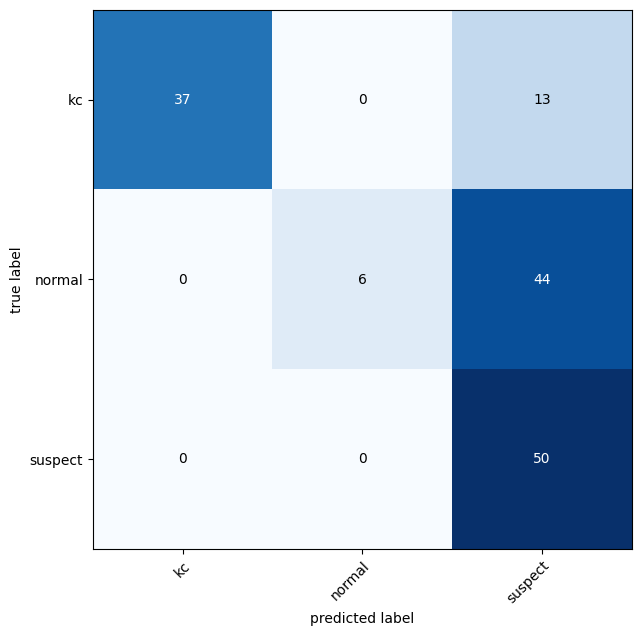

In [ ]:
from tqdm.auto import tqdm
y_preds = []
combined_model_vit_eff.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_pretrained, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = combined_model_vit_eff(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_ptch_comb = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_ptch_comb,
                         target=test_data.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

Now combining `vit` and `efficientb0` and add `resnet` and `vgg16`

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, resnet50, vgg16, vit_b_16

# Load pre-trained models
efficientnet = efficientnet_b0(pretrained=True)
efficientnet.classifier = nn.Identity()  # Remove the classification layer

resnet = resnet50(pretrained=True)
resnet.fc = nn.Identity()  # Remove the classification layer

vgg = vgg16(pretrained=True)
vgg.classifier = nn.Sequential(*list(vgg.classifier.children())[:-1])  # Remove the last classification layer

vit = vit_b_16(pretrained=True)
vit.heads = nn.Identity()  # Remove the classification head

# Freeze parameters of EfficientNet-B0, ResNet, and VGG16
for param in efficientnet.parameters():
    param.requires_grad = False

for param in resnet.parameters():
    param.requires_grad = False

for param in vgg.parameters():
    param.requires_grad = False

# Also freeze ViT parameters, as requested
for param in vit.parameters():
    param.requires_grad = False


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most u

In [ ]:
class CombinedModel_2(nn.Module):
    def __init__(self, efficientnet, resnet, vgg, vit, num_classes):
        super(CombinedModel_2, self).__init__()
        self.efficientnet = efficientnet
        self.resnet = resnet
        self.vgg = vgg
        self.vit = vit

        # Assuming feature dimensions: EfficientNet (1280), ResNet (2048), VGG (4096), ViT (768)
        self.feature_dim = 1280 + 2048 + 4096 + 768

        self.classifier = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            efficientnet_features = self.efficientnet(x)
            resnet_features = self.resnet(x)
            vgg_features = self.vgg(x)

        vit_embeddings = self.vit(x)

        # Concatenate features and embeddings
        combined_features = torch.cat((efficientnet_features, resnet_features, vgg_features, vit_embeddings), dim=1)

        # Pass through the classifier
        output = self.classifier(combined_features)
        return output

# Assuming number of classes is 1000
num_classes = 3
combined_model_vit_eff_vgg_resnet = CombinedModel_2(efficientnet, resnet, vgg, vit, num_classes = 3).to(device)


In [ ]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)
optimizer_vit_eff_vgg_resnet = torch.optim.Adam(params=combined_model_vit_eff_vgg_resnet.parameters(),
                             lr=0.001)
from timeit import default_timer as timer
start_time = timer()
pretrained_vit_results_comb = engine.train(model=combined_model_vit_eff_vgg_resnet,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer_vit_eff_vgg_resnet,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.7724 | train_acc: 0.6301 | test_loss: 1.9255 | test_acc: 0.4625
Epoch: 2 | train_loss: 0.7172 | train_acc: 0.6996 | test_loss: 1.2793 | test_acc: 0.5312
Epoch: 3 | train_loss: 0.5117 | train_acc: 0.8013 | test_loss: 0.6202 | test_acc: 0.7318
Epoch: 4 | train_loss: 0.5167 | train_acc: 0.7675 | test_loss: 0.8552 | test_acc: 0.6188
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.7985 | test_loss: 0.8714 | test_acc: 0.6312
Epoch: 6 | train_loss: 0.4824 | train_acc: 0.7809 | test_loss: 0.6952 | test_acc: 0.6750
Epoch: 7 | train_loss: 0.3708 | train_acc: 0.8256 | test_loss: 1.1528 | test_acc: 0.5750
Epoch: 8 | train_loss: 0.3410 | train_acc: 0.8469 | test_loss: 0.6675 | test_acc: 0.6909
Epoch: 9 | train_loss: 0.3432 | train_acc: 0.8527 | test_loss: 0.9084 | test_acc: 0.6034
Epoch: 10 | train_loss: 0.3313 | train_acc: 0.8390 | test_loss: 0.6871 | test_acc: 0.7068
Total training time: 163.677 seconds


Making predictions:   0%|          | 0/5 [00:00<?, ?it/s]

mlxtend version: 0.23.1


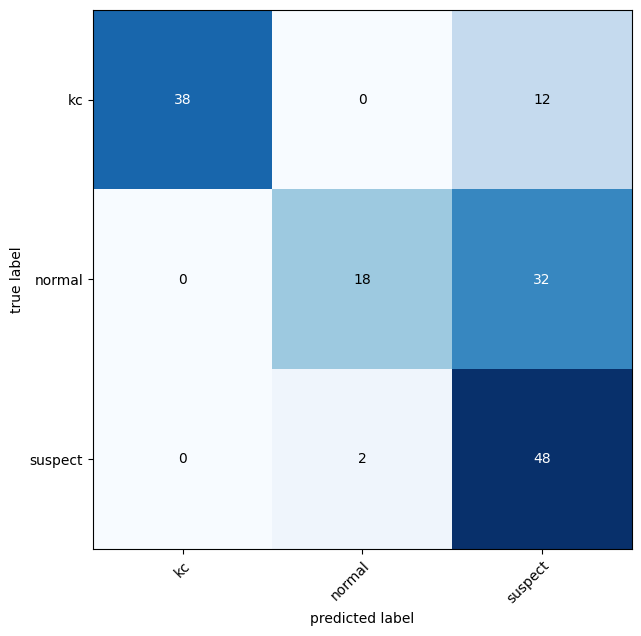

In [ ]:
from tqdm.auto import tqdm
y_preds = []
combined_model_vit_eff_vgg_resnet.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_pretrained, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = combined_model_vit_eff_vgg_resnet(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_ptch_comb_2 = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_ptch_comb_2,
                         target=test_data.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, resnet50, vgg16, vit_b_16 , vit_b_32

# Load pre-trained models
efficientnet = efficientnet_b0(pretrained=True)
efficientnet.classifier = nn.Identity()  # Remove the classification layer

resnet = resnet50(pretrained=True)
resnet.fc = nn.Identity()  # Remove the classification layer

vgg = vgg16(pretrained=True)
vgg.classifier = nn.Sequential(*list(vgg.classifier.children())[:-1])  # Remove the last classification layer

# Freeze parameters of EfficientNet-B0, ResNet, and VGG16
for param in efficientnet.parameters():
    param.requires_grad = False

for param in resnet.parameters():
    param.requires_grad = False

for param in vgg.parameters():
    param.requires_grad = False
vit = vit_b_16(pretrained=True)
vit.heads = nn.Identity()
for param in vit.parameters():
  param.requires_grad = False

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, efficientnet):#, resnet):#, vgg):
        super(FeatureExtractor, self).__init__()
        self.efficientnet = efficientnet
        #self.resnet = resnet
        #self.vgg = vgg

    def forward(self, x):
        with torch.no_grad():
            efficientnet_features = self.efficientnet(x)
            #resnet_features = self.resnet(x)
            #vgg_features = self.vgg(x)

        # Concatenate the features along the feature dimension
        #combined_features = torch.cat((efficientnet_features, resnet_features, vgg_features), dim=1)
        #combined_features = torch.cat((efficientnet_features, resnet_features), dim=1)
        combined_features = efficientnet_features
        return combined_features

#feature_extractor = FeatureExtractor(efficientnet, resnet, vgg)
#feature_extractor = FeatureExtractor(efficientnet, resnet)
feature_extractor = FeatureExtractor(efficientnet).to(device)

In [ ]:
input_tensor = torch.randn(1, 3, 224, 224).to(device)
feature_extractor(input_tensor).shape


torch.Size([1, 1280])

In [ ]:
class ViTWithFeatures(nn.Module):
    def __init__(self, feature_extractor, vit, combined_feature_dim, num_classes):
        super(ViTWithFeatures, self).__init__()
        self.feature_extractor = feature_extractor
        self.vit = vit


        self.vit.conv_proj = nn.Conv2d(combined_feature_dim, self.vit.conv_proj.out_channels, kernel_size=1, stride=1)
        self.classifier = nn.Linear(self.vit.hidden_dim, num_classes)

    def forward(self, x):
        combined_features = self.feature_extractor(x)


        batch_size = combined_features.size(0)
        combined_features = combined_features.view(batch_size, combined_features.size(1), 1, 1)


        combined_features = nn.functional.interpolate(combined_features, size=(224, 224))


        vit_embeddings = self.vit(combined_features)
        cls_token_embedding = vit_embeddings[:, 0, :]
        output = self.classifier(cls_token_embedding)
        return output

# Assuming combined feature dim: EfficientNet (1280) + ResNet (2048) + VGG (4096) = 7424
#combined_feature_dim = 1280 + 2048 + 4096
#combined_feature_dim = 1280 + 2048
combined_feature_dim = 1280
num_classes = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
vit_with_features = ViTWithFeatures(feature_extractor, vit, combined_feature_dim, num_classes).to(device)


In [ ]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)
optimizer_vit_with_features = torch.optim.Adam(params=vit_with_features.parameters(),
                             lr=0.001)
from timeit import default_timer as timer
start_time = timer()
pretrained_vit_results_comb = engine.train(model=vit_with_features,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer_vit_with_features,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]